### Understanding UMAP embeddings

In [1]:
import os
import torch
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import plotly.express as px
from univ_utils import get_umap_embeddings, load_model, load_sae
device = "cuda" if torch.cuda.is_available() else "cpu"

/home/zara-ss/Documents/feature_universality/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
cos_sims_matrix = lambda array: np.triu(array @ array.transpose())
cos_sims = lambda array: cos_sims_matrix(array)[cos_sims_matrix(array) != 0].flatten()
out_dir = lambda model_name, sae_name: os.path.join("sae_checkpoints", f"{model_name}-final", sae_name, "final_1024000000")

#### Get all UMAP embeddings

In [13]:
model_to_saes_dict = {"8-128": "ngd29532",
                      "8-256": "7g6hq05j",
                      "8-512": "fyqbawtf",
                      "8-768": "443ngubm",
                      }

umap_embeddings = {}
W_decs = {}
for model_name, sae_name in model_to_saes_dict.items():
    sae = load_sae(sae_name=sae_name, device=device, ckpt_iter=None, model_name=model_name)
    assert sae.cfg.d_in == int(model_name.split("-")[1]), "You may have loaded the wrong model or SAE"

    W_dec = sae.W_dec.clone().detach().cpu().numpy()
    W_decs[(model_name, sae_name)] = W_dec
    umap_embeddings[(model_name, sae_name)] = get_umap_embeddings(W_dec)


/home/zara-ss/Documents/feature_universality/SAELens/sae_lens/sae.py:145: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(
/home/zara-ss/Documents/feature_universality/env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/zara-ss/Documents/feature_universality/SAELens/sae_lens/sae.py:145: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(
/home/zara-ss/Documents/feature_universality/env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed f

#### 8-128

/tmp/ipykernel_447874/106608998.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], cmap='viridis')


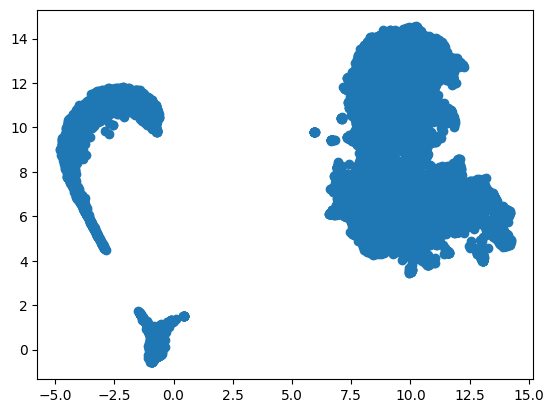

In [32]:
model_name = "8-128"
sae_name = "ngd29532"

W_dec = W_decs[(model_name, sae_name)]
umap_embedding = umap_embeddings[(model_name, sae_name)]
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], cmap='viridis')
plt.show()

In [33]:
top_left_cluster_indices = (umap_embedding[:, 0] < 0.5) & (umap_embedding[:, 1] > 4)
bottom_left_cluster_indices = (umap_embedding[:, 0] < 0.5) & (umap_embedding[:, 1] < 2)
main_cluster_indices = np.logical_not(np.logical_or(bottom_left_cluster_indices, top_left_cluster_indices))

In [34]:
top_left_cluster = umap_embedding[top_left_cluster_indices]
bottom_left_cluster = umap_embedding[bottom_left_cluster_indices]
main_cluster = umap_embedding[main_cluster_indices]

In [35]:
top_left_mutual_cos_sims = cos_sims(W_dec[top_left_cluster_indices])
print(np.median(top_left_mutual_cos_sims), np.min(top_left_mutual_cos_sims))
bottom_left_mutual_cos_sims = cos_sims(W_dec[bottom_left_cluster_indices])
print(np.median(bottom_left_mutual_cos_sims), np.min(bottom_left_mutual_cos_sims))
main_mutual_cos_sims = cos_sims(W_dec[main_cluster_indices])
print(np.median(main_mutual_cos_sims), np.min(main_mutual_cos_sims))

0.9999994 0.9999731
0.780786 -0.31464383
0.0047637247 -0.7826308


Top left cluster is all pointing in the same direction. Bottom left has a lot more variation but when I looked at the dashboards, I found that they were also uninterpretable. So I will also remove them for now.

In [36]:
torch.save(main_cluster_indices, os.path.join(out_dir("8-128", "ngd29532"), "main_cluster_indices.pt"))
torch.save(bottom_left_cluster_indices, os.path.join(out_dir("8-128", "ngd29532"), "bottom_left_cluster_indices.pt"))
torch.save(top_left_cluster_indices, os.path.join(out_dir("8-128", "ngd29532"), "top_left_cluster_indices.pt"))

In [38]:
uninterpretable_cluster_indices = np.logical_or(bottom_left_cluster_indices, top_left_cluster_indices)
torch.save(uninterpretable_cluster_indices, os.path.join(out_dir("8-128", "ngd29532"), "uninterpretable_cluster_indices.pt"))
torch.save(main_cluster_indices, os.path.join(out_dir("8-128", "ngd29532"), "interpretable_cluster_indices.pt"))

#### 8-256

/tmp/ipykernel_447874/3683445535.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], cmap='viridis')


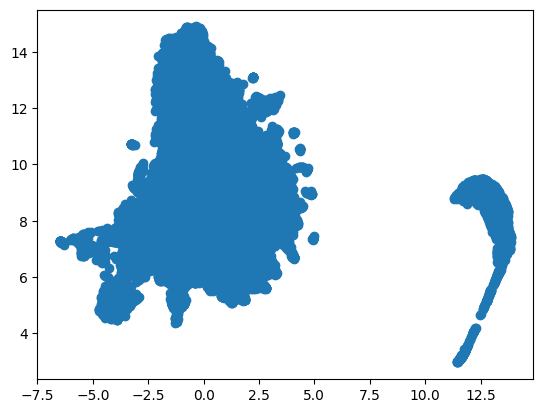

In [42]:
model_name = "8-256"
sae_name = "7g6hq05j"

W_dec = W_decs[(model_name, sae_name)]
umap_embedding = umap_embeddings[(model_name, sae_name)]
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], cmap='viridis')
plt.show()

In [43]:
right_cluster_indices = (umap_embedding[:, 0] > 7.5)
left_cluster_indices = (umap_embedding[:, 0] < 7.5)
right_mutual_cos_sims = cos_sims(W_dec[right_cluster_indices])
print(np.median(right_mutual_cos_sims), np.min(right_mutual_cos_sims))
left_mutual_cos_sims = cos_sims(W_dec[left_cluster_indices])
print(np.median(left_mutual_cos_sims), np.min(left_mutual_cos_sims))

0.9999996 -0.4110024
0.0045853485 -0.8337815


In [44]:
right_cluster_indices.sum(), left_cluster_indices.sum()

(1040, 23536)

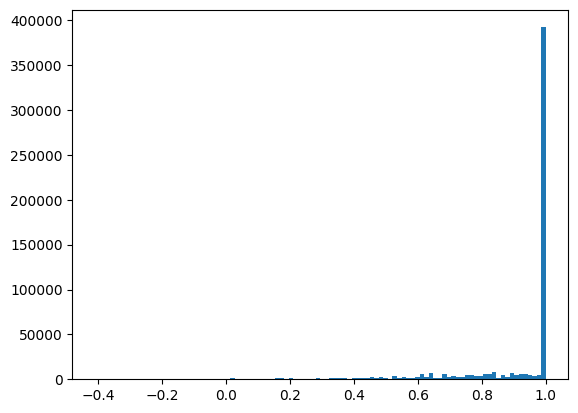

In [45]:
plt.hist(right_mutual_cos_sims, bins=100)
plt.show()

In [46]:
torch.save(right_cluster_indices, os.path.join(out_dir(model_name, sae_name), "uninterpretable_cluster_indices.pt"))
torch.save(left_cluster_indices, os.path.join(out_dir(model_name, sae_name), "interpretable_cluster_indices.pt"))

Most likely, the right cluster is uninterpretable and left cluster is not. I should check this by making dashboards.

#### 8-512

/tmp/ipykernel_447874/195113252.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], cmap='viridis')


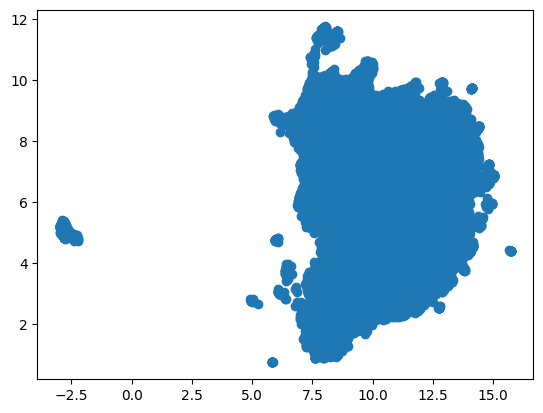

In [47]:
model_name = "8-512"
sae_name = "fyqbawtf"

W_dec = W_decs[(model_name, sae_name)]
umap_embedding = umap_embeddings[(model_name, sae_name)]
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], cmap='viridis')
plt.show()

In [48]:
left_cluster_indices = (umap_embedding[:, 0] < 0.0)
right_cluster_indices = (umap_embedding[:, 0] > 0.0)
left_mutual_cos_sims = cos_sims(W_dec[left_cluster_indices])
print(np.median(left_mutual_cos_sims), np.min(left_mutual_cos_sims))
right_mutual_cos_sims = cos_sims(W_dec[right_cluster_indices])
print(np.median(right_mutual_cos_sims), np.min(right_mutual_cos_sims))
left_cluster_indices.sum(), right_cluster_indices.sum()
## Dashboards

0.99538684 -0.08060951
0.0032167616 -0.81084824


(253, 24323)

Yes so left cluster here is most likely uninterpretable.

In [49]:
torch.save(left_cluster_indices, os.path.join(out_dir(model_name, sae_name), "uninterpretable_cluster_indices.pt"))
torch.save(right_cluster_indices, os.path.join(out_dir(model_name, sae_name), "interpretable_cluster_indices.pt"))

#### 8-768

/tmp/ipykernel_447874/736370843.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], cmap='viridis')


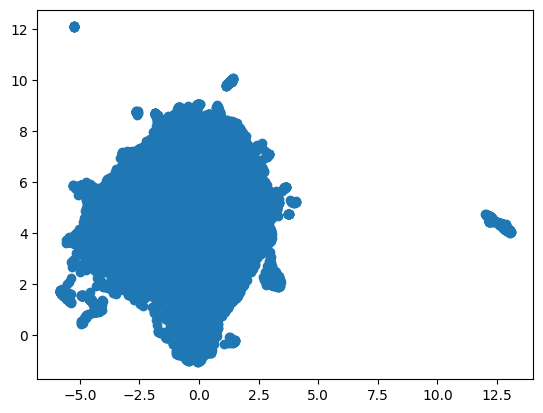

In [50]:
model_name = "8-768"
sae_name = "443ngubm"

W_dec = W_decs[(model_name, sae_name)]
umap_embedding = umap_embeddings[(model_name, sae_name)]
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], cmap='viridis')
plt.show()

In [51]:
# right cluster is most likely uninterpretable.
right_cluster_indices = (umap_embedding[:, 0] > 10.0)
left_cluster_indices = (umap_embedding[:, 0] < 10.0)
right_mutual_cos_sims = cos_sims(W_dec[right_cluster_indices])
print(np.median(right_mutual_cos_sims), np.min(right_mutual_cos_sims))
left_mutual_cos_sims = cos_sims(W_dec[left_cluster_indices])
print(np.median(left_mutual_cos_sims), np.min(left_mutual_cos_sims))
right_cluster_indices.sum(), left_cluster_indices.sum()


0.9943066 0.023957709
0.0024038677 -0.86287683


(261, 24315)

In [52]:
torch.save(right_cluster_indices, os.path.join(out_dir(model_name, sae_name), "uninterpretable_cluster_indices.pt"))
torch.save(left_cluster_indices, os.path.join(out_dir(model_name, sae_name), "interpretable_cluster_indices.pt"))

## Dashboards

### Imports and initialization

In [ ]:
# type: ignore
try:
    import google.colab  
    from google.colab import output

    COLAB = True
    %pip install sae-lens transformer-lens sae-dashboard
except:
    COLAB = False
    from IPython import get_ipython  # type: ignore

    ipython = get_ipython()
    assert ipython is not None
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

# Standard imports
import os
import torch


# Imports for displaying vis in Colab / notebook
import webbrowser
import http.server
import socketserver
import threading

PORT = 8000

torch.set_grad_enabled(False);

device = "cuda" if torch.cuda.is_available() else "cpu"
from univ_utils import load_model, load_sae, load_data, get_batch

In [ ]:
# For the most part I'll try to import functions and classes near where they are used
# to make it clear where they come from.

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

In [ ]:
def display_vis_inline(filename: str, height: int = 850):
    """
    Displays the HTML files in Colab. Uses global `PORT` variable defined in prev cell, so that each
    vis has a unique port without having to define a port within the function.
    """
    if not (COLAB):
        webbrowser.open(filename)

    else:
        global PORT

        def serve(directory):
            os.chdir(directory)

            # Create a handler for serving files
            handler = http.server.SimpleHTTPRequestHandler

            # Create a socket server with the handler
            with socketserver.TCPServer(("", PORT), handler) as httpd:
                print(f"Serving files from {directory} on port {PORT}")
                httpd.serve_forever()

        thread = threading.Thread(target=serve, args=("/content",))
        thread.start()

        output.serve_kernel_port_as_iframe(
            PORT, path=f"/{filename}", height=height, cache_in_notebook=True
        )

        PORT += 1

### Generating dashboards

In [9]:
import random

In [ ]:
data, _ = load_data(dataset="openwebtext", device=device)

# TODO: ideally want to do more than 10k tokens
owt_tokens, _ = get_batch(data, block_size=sae.cfg.context_size, batch_size=int(1e5))

(owt_tokens.shape[0] * owt_tokens.shape[1]) / 1e8

In [ ]:
bottom_left_cluster_indices.sum(), top_left_cluster_indices.sum(), boolean_tensor.sum()

In [ ]:
main_cluster_indices = np.logical_not(np.logical_or(bottom_left_cluster_indices, top_left_cluster_indices))
main_cluster_indices.sum()

In [67]:
random_bottom_left_features = random.choices((bottom_left_cluster_indices).nonzero()[0], k=10)
random_top_left_features = random.choices((top_left_cluster_indices).nonzero()[0], k=10)
random_main_features = random.choices(main_cluster_indices.nonzero()[0], k=10)

In [71]:
features = random_main_features

In [ ]:
features

In [ ]:
from sae_dashboard.sae_vis_data import SaeVisConfig
feature_vis_config_gpt = SaeVisConfig(
    hook_point=sae.cfg.hook_name,
    features=features,
    minibatch_size_features=64,
    minibatch_size_tokens=256,
    verbose=True,
    device=device,
)

from sae_dashboard.sae_vis_runner import SaeVisRunner
visualization_data_gpt = SaeVisRunner(feature_vis_config_gpt).run(
    encoder=sae,  # type: ignore
    model=model,
    tokens=owt_tokens[:10000],  # type: ignore
)

type(visualization_data_gpt)

In [ ]:
from sae_dashboard.data_writing_fns import save_feature_centric_vis
features_type = "top_left" if features == random_top_left_features else "bottom_left" if features == random_bottom_left_features else "main"
filename_fn = lambda features : f"dashboards/dashboards_{sae_name}_{features_type}_{'_'.join(map(str, features))}.html"
filename = filename_fn(features)
save_feature_centric_vis(sae_vis_data=visualization_data_gpt, filename=filename)
display_vis_inline(filename=filename)